## Ingestion

First, import the needed python libraries and then read in the water temperature data from a csv file

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
raw_temps = pd.read_csv("raw_data/water_temps_kok002.csv",header=2)
dt = pd.to_datetime(raw_temps['Timestamp (UTC-08:00)'])
temps = pd.DataFrame({'Timestamp':dt,'Temperature':raw_temps['Value (Celsius)']})

## Process

The data is hourly, with the odd gap. Convert to a monthly average

In [3]:
temps['year'] = temps['Timestamp'].apply(lambda x: x.year)
temps['month'] = temps['Timestamp'].apply(lambda x: x.month)

In [4]:
def build_averages(*groupCols):
    mean_temp = temps.groupby(groupCols).mean()['Temperature']
    var_temp = temps.groupby(groupCols).var()['Temperature']
    return pd.DataFrame({'Mean':mean_temp,'Variance':var_temp}).reset_index()

In [5]:
per_month = build_averages('year','month')
per_month['start_date'] = per_month.apply(lambda x: datetime(year=int(x['year']),month=int(x['month']),day=1),axis=1)

## Present

We can now show off the results. For now, just a simple plot

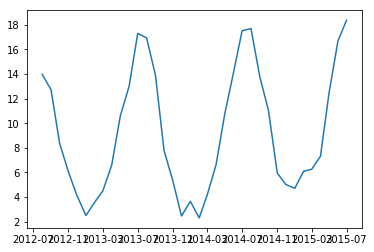

In [6]:
plt.plot(per_month['start_date'],per_month['Mean'])

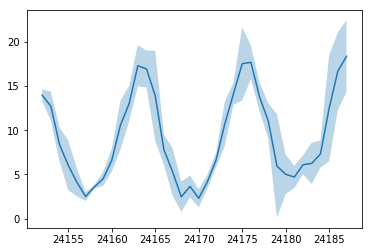

In [7]:
per_month['sd_num'] = per_month.apply(lambda x: x['year']*12 + x['month'],axis=1)
plt.plot(per_month['sd_num'],per_month['Mean'])
per_month['up'] = per_month['Mean'] + per_month['Variance']
per_month['dn'] = per_month['Mean'] - per_month['Variance']
plt.fill_between(per_month['sd_num'], per_month['up'], per_month['dn'], alpha=0.3)

In [8]:
per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
year          36 non-null int64
month         36 non-null int64
Mean          36 non-null float64
Variance      36 non-null float64
start_date    36 non-null datetime64[ns]
sd_num        36 non-null int64
up            36 non-null float64
dn            36 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.3 KB


## Fourier Filtering

The monthly data, despite the averaging, is quite raw. Filtering out some of the noise is possible by using a fourier transformation and then removing the higher-freequency components.

In [9]:
from scipy import fftpack
def fourier_trimming(raw_data, split=9):
    omega = fftpack.fft(raw_data)
    reproc_raw = fftpack.fft(omega)
    # Filter out high frequency component
    mid = int(len(omega)/2)
    for i in range(mid-split,mid+split):
        omega[i] = 0
    reproc_filtered = fftpack.fft(omega)
    # Reverse data if needed
    ln = len(raw_data) - 1
    initial = raw_data[0] > raw_data[ln]
    final = reproc_raw[0] > reproc_raw[ln]
    if initial != final:
        reproc_filtered = np.flip(reproc_filtered,axis=0)
        reproc_raw = np.flip(reproc_raw,axis=0)
    
    return (reproc_filtered, reproc_raw)

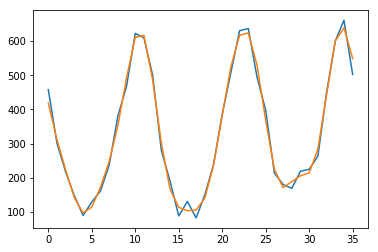

In [10]:
filt, raw = fourier_trimming(per_month['Mean'])
plt.plot(np.abs(raw))
plt.plot(np.abs(filt))

## Daily effects

Returning to the raw data - can we see short-term temperature effects such as daily or from the lunar month?

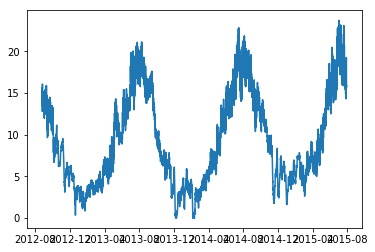

In [11]:
plt.plot(temps["Timestamp"],temps["Temperature"])

In [12]:
daily_omega = fftpack.fft(temps["Temperature"].dropna())
daily_omega

array([ 235191.11600000    +0.j        ,     506.12635208 +9366.28162823j,
         -9926.03253068 +3220.69299298j, ...,
         83825.41728749-27343.73475988j,   -9926.03253068 -3220.69299298j,
           506.12635208 -9366.28162823j])

Text(0.5,0.98,'Frequency spectrum of temperature data')

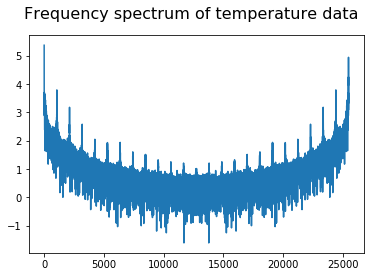

In [13]:
plt.plot(np.log10(np.abs(daily_omega)))
plt.suptitle("Frequency spectrum of temperature data", fontsize=16)

In [14]:
yearFreq = 3
monthFreq = yearFreq * 12
dayFreq = yearFreq * 365
lunarFreq = int(dayFreq / 29)
hourFreq = dayFreq * 24

print(monthFreq,dayFreq,lunarFreq,hourFreq)

36 1095 37 26280


(0, 1500)

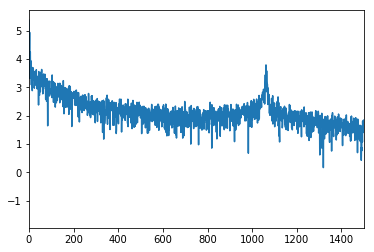

In [15]:
plt.plot(np.log10(np.abs(daily_omega)))
plt.gca().set_xlim([0,1500])

(0, 100)

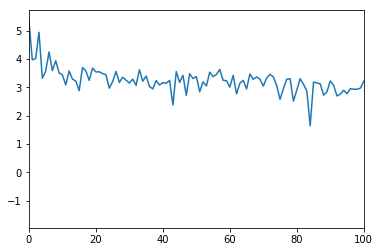

In [16]:
plt.plot(np.log10(np.abs(daily_omega)))
plt.gca().set_xlim([0,100])